In [0]:
'''
Colab or Local Settings
'''

colab = True

test_data_path = None
data_root = None
aug_data = None
val_data = None
predict_save_path = None
trial_num = 0

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
    data_root = '/content/drive/My Drive/ECE542_sp20_CompetitionData/'
    val_data = '/content/drive/My Drive/ECE 542 Competition Project/val_data/'
    aug_data = '/content/drive/My Drive/ECE 542 Competition Project/aug_training/'
    test_data_path = '/content/drive/My Drive/ECE542_sp20_CompetitionData/TestData/'
    predict_save_path = "/content/drive/My Drive/ECE 542 Competition Project/predictions/predict.csv"
else:
    data_root = './'
    aug_data = './aug_training/'
    val_data = './val_data/'
    test_data_path = './TestData/'
    predict_save_path = './predictions/predict.csv'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### Load Data and Annotations
import pandas as pd
import numpy as np
import os
from keras.utils import to_categorical
import cv2
#annotations_df = pd.read_csv(data_root + '/TrainAnnotations.csv')
im_path = data_root + "/TrainData/"

def csv_to_list(filepath):
  df = pd.read_csv(filepath)
  return df.values.tolist()

def get_images_and_labels(data_list):
  global im_path
  filepaths, labels = map(list, zip(*data_list)) #generates two lists from a list of two element lists
  num_images = len(labels)
  images = [ cv2.imread(os.path.join(im_path, f)) for f in filepaths ] 
  images = np.array(images) ## RGB image has 3 channels
  labels = np.asarray(labels, dtype=np.float64)
  return np.reshape(images, (num_images, 480, 640, 3)), to_categorical(labels)

                       

Using TensorFlow backend.


Text(0, 0.5, 'Count')

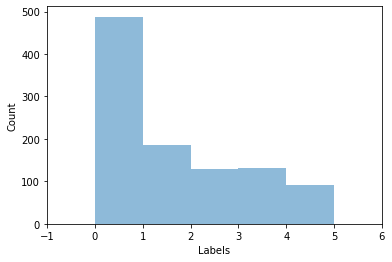

In [0]:
# Examining Data 

# Label Histogram
import numpy as np
from matplotlib import pyplot as plt

data = csv_to_list(data_root + 'TrainAnnotations.csv')

images, labels = map(list, zip(*data))


bins = np.arange(-1,7,1)
plt.xlim([-1,6])

plt.hist(labels, bins=bins, alpha = 0.5)
plt.xlabel('Labels')
plt.ylabel('Count')

From the histogram, it can be determined that the data is heavily biased towards 0 labels/healthy plants.

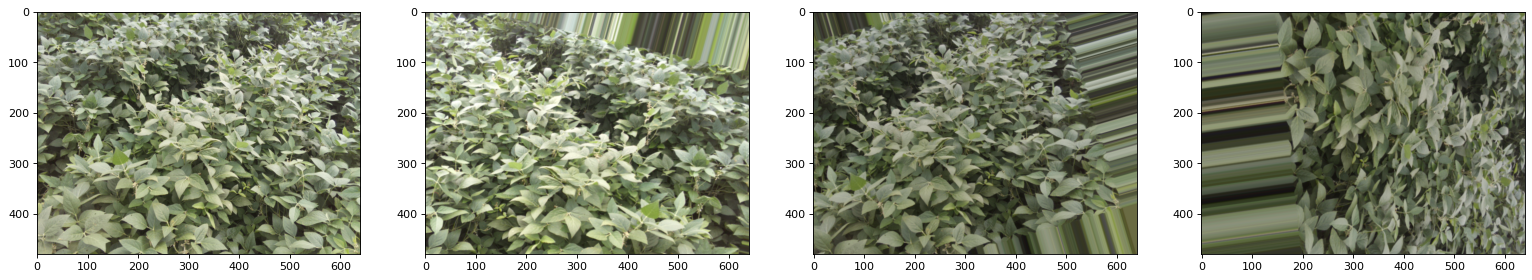

In [0]:
# Data Preparation
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt
from numpy import expand_dims
import csv
import os
from os.path import isfile, join
from os import walk, listdir
from shutil import copy2 as copy_file

class AugmentationException(Exception):
  pass

def augment_data(images, labels, batch_size=32):
  #returns an iterator that generates augmented data
  #during training
  image_gen = ImageDataGenerator( # Select which will improve performance
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    #vertical_flip=True,
    height_shift_range=0.15,
    width_shift_range=0.15,
    shear_range=0.15,
    brightness_range=[0.75,1.25],
    zoom_range=[0.75,1.0],
    fill_mode='nearest',
    #cval=0
  )

  #image_gen.fit(images)
  return image_gen

def image_gen_visualizer():
  #plots the original image followed by 3 images generated by the image generator specified
  #load sample image from training set
  global im_path
  fig=plt.figure(figsize=(24, 22), dpi= 80, facecolor='w', edgecolor='k')
  image = load_img(im_path + '005735.jpg')
  data = img_to_array(image)
  sample = expand_dims(data, 0)
  plt.subplot(140+1)
  plt.imshow(image)

  image_gen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    #vertical_flip=True,
    height_shift_range=0.15,
    width_shift_range=0.15,
    shear_range=0.15,
    brightness_range=[0.75,1.25],
    zoom_range=[0.75,1.0],
    fill_mode='nearest',
    cval=0
  )
  image_gen.fit(sample)
  it = image_gen.flow(sample, batch_size=1)

  for i in range(3):
    plt.subplot(140+2+i)
    plt.imshow(it.next()[0].astype('uint8'))


def save_aug_data_to_directory(batch_size=32,total_num_images=8192,num_validation_images = 100):
  global val_data
  global data_root
  for dirpath, dirnames, filenames in walk(aug_data):
      if filenames:
          raise AugmentationException('Augmented Data Directory is not empty: {}'.format(filenames))
  print('Augmenting Data')
  data_list = csv_to_list(data_root + 'TrainAnnotations.csv')
  num_items = len(data_list)
  
  training_data_list = data_list[:num_items - num_validation_images]
  validation_data_list = data_list[-num_validation_images:]
  
  training_label_dictionary = {
      0:[],
      1:[],
      2:[],
      3:[],
      4:[]
  }

  #Create a dictionary to separate training images into classes
  for ts in training_data_list:
      training_label_dictionary[ts[1]].append(ts[0])

  #Copy images from validation set into directory structure
  for val_img in validation_data_list:
      copy_file(im_path + val_img[0], val_data + str(val_img[1]) + '/')

  # Iterate over every key and create image tensors to flow over
  for key in training_label_dictionary.keys():
      print("Augmenting class " + str(key))
      filepath_list = training_label_dictionary[key]
      num_images = len(filepath_list)
      image_list = [ cv2.imread(im_path + path) for path in filepath_list ]
      print(image_list[0].shape)
      images = np.array(image_list) # array of images
      images = np.reshape(images, (num_images, 480, 640, 3)) # tensor of images

      image_gen = ImageDataGenerator( # Select which will improve performance
          #rescale=1./255,
          rotation_range=40,
          horizontal_flip=True,
          #vertical_flip=True,
          height_shift_range=0.15,
          width_shift_range=0.15,
          shear_range=0.15,
          brightness_range=[0.75,1.25],
          zoom_range=[0.75,1.0],
          fill_mode='nearest',
          #cval=0,
          dtype=np.uint8
      )

      image_gen.fit(images)

      #generate images and store them into directory specified by key
      tr_it = image_gen.flow(
          x=images, 
          save_to_dir=str(aug_data + str(key)),
          batch_size=batch_size,
          save_format='jpeg',
          save_prefix='class-' + str(key) +'-' +'aug',
      )
      
      #create batches and save to directory
      for i in range(0,total_num_images, batch_size):
          tr_it.next()    


image_gen_visualizer() 

In [0]:
### Base Convolutional Network

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Flatten, Dropout
from keras.utils import plot_model
import cv2

trial = 0
model_path = None

if colab:
    model_path = "/content/drive/My Drive/ECE 542 Competition Project/models/trial-" + str(trial)+ '/'
else:
    model_path = './models/trial-' + str(trial) + '/'

def generate_model(shape): # Best is 0.71
  conv_net = Sequential()
  #Using a sequential model makes it easy to build custom nets

  conv_net.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=shape))
  #conv_net.add(BatchNormalization())
  conv_net.add(MaxPool2D(pool_size=(2,2)))

  conv_net.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
  conv_net.add(MaxPool2D(pool_size=(2,2)))

  conv_net.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
  conv_net.add(MaxPool2D(pool_size=(2,2)))

  conv_net.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
  conv_net.add(MaxPool2D(pool_size=(2,2)))

  conv_net.add(Flatten())
  
  conv_net.add(Dense(64, activation="relu"))
  conv_net.add(Dropout(0.5))
  conv_net.add(Dense(5, activation="softmax"))

  plot_model(conv_net, to_file=model_path + '/model.png', show_shapes=True)

  conv_net.summary()
  return conv_net

generate_model((480,640,3))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 478, 638, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 239, 319, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 237, 317, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 118, 158, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 116, 156, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 58, 78, 64)        0         


In [0]:
# Train Model
import keras
from sklearn.metrics import classification_report
import numpy as np

#Use Stored Augmented Data
training_generator = None
validation_generator = None
try:
    save_aug_data_to_directory()
except AugmentationException as e:
    print(e)
except Exception:
    raise
finally:
    # Create generator
    training_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(aug_data, target_size=(480,640))
    validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data, target_size=(480,640))

model = generate_model((480,640,3))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    model_path + "best_model_{epoch:02d}_{loss:.4f}.h5", 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', 
    period=1)

history = model.fit_generator(
    generator=training_generator, 
    steps_per_epoch=512, 
    epochs=14, 
    validation_data=validation_generator,
    callbacks=[checkpoint_callback],
    use_multiprocessing=True,
    workers=2
)

#Save Final Model
model.save(model_path + "trained_model.h5")

# Get Global Statistics
validation_predictions = model.predict(validation_generator)
validation_pred_bool = np.argmax(validation_predictions, axis=1)

print(classification_report(np.argmax(y_valid, axis=1), validation_pred_bool))

# Plot training & validation loss values
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

Augmented Data Directory is not empty: ['class-0-aug_221_2450.jpeg', 'class-0-aug_329_1364.jpeg', 'class-0-aug_231_4751.jpeg', 'class-0-aug_399_1368.jpeg', 'class-0-aug_293_7966.jpeg', 'class-0-aug_88_5275.jpeg', 'class-0-aug_92_3332.jpeg', 'class-0-aug_208_4432.jpeg', 'class-0-aug_48_5703.jpeg', 'class-0-aug_286_2986.jpeg', 'class-0-aug_319_6349.jpeg', 'class-0-aug_190_8271.jpeg', 'class-0-aug_189_352.jpeg', 'class-0-aug_322_4530.jpeg', 'class-0-aug_79_2110.jpeg', 'class-0-aug_25_3554.jpeg', 'class-0-aug_53_531.jpeg', 'class-0-aug_205_2455.jpeg', 'class-0-aug_355_9860.jpeg', 'class-0-aug_333_6440.jpeg', 'class-0-aug_49_6393.jpeg', 'class-0-aug_54_9017.jpeg', 'class-0-aug_310_7732.jpeg', 'class-0-aug_230_4701.jpeg', 'class-0-aug_426_8994.jpeg', 'class-0-aug_431_9737.jpeg', 'class-0-aug_198_7413.jpeg', 'class-0-aug_93_1821.jpeg', 'class-0-aug_148_549.jpeg', 'class-0-aug_236_8044.jpeg', 'class-0-aug_393_262.jpeg', 'class-0-aug_422_4189.jpeg', 'class-0-aug_105_2973.jpeg', 'class-0-aug_176

NameError: ignored

In [0]:
#Load Testing Data
from os import listdir, walk
from os.path import isfile
import cv2
import numpy as np


test_images = []

for (dirpath, directories, filepaths) in walk(test_data_path):
  test_images.extend([cv2.imread(test_data_path + f)/255 for f in filepaths]) #Already rescaled

test_images = np.array(test_images)

In [0]:
# Load Trained model
from keras.models import load_model

trained_model_path = None
if colab:
    trained_model_path = '/content/gdrive/My Drive/ECE 542 Competition Project/models/trial-' + str(trial) + '/trained_model.h5'
else:
    trained_model_path = './models/trial-' + str(trial) + '/trained_model.h5'

test_model = load_model(trained_model_path)

In [0]:
#Get Validation Statistics
from sklearn.metrics import classification_report
import numpy as np

#test_model = model
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data, target_size=(480,640))
validation_predictions = test_model.predict(validation_generator)
validation_pred_bool = np.argmax(validation_predictions, axis=1)

print(classification_report(np.argmax(y_valid, axis=1), validation_pred_bool))

In [0]:
# Get Test Predictions
import csv



predictions = test_model.predict(test_images)
predictions = [np.argmax(prediction) for prediction in predictions]
predictions = to_categorical(predictions)

with open(predict_save_path, 'w') as f:
  csv_writer = csv.writer(f, delimiter=',')
  csv_writer.writerows(predictions)

In [0]:
# generate the predictions
import os
import cv2
import numpy as np
import pandas as pd

im_paths = "/content/drive/My Drive/ECE 542 Competition Project/test_data/TestData/"

import glob
cv_img = []
for img in glob.glob("/content/drive/My Drive/ECE 542 Competition Project/test_data/TestData/*.jpg"):
    n= cv2.imread(img)
    cv_img.append(n)

print(len(cv_img))

# generate the predictions for the test_data

y_prob = model.predict(cv_img) 
y_classes = y_prob.argmax(axis=-1)

print(y_prob)
print(y_classes)

prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')

# one hot encode
encoded = to_categorical(y_prob)

encoded_df = pd.DataFrame(encoded)
filepath = 'predictions.xlsx'
filename = 'predictions.csv'
encoded_df.to_excel(filepath, index=False)
encoded_df.to_csv(filename, sep=',', index=False, header=False)

In [0]:
import sklearn.metrics as metrics

cm = metrics.confusion_matrix(np.argmax(y_valid, axis=1), validation_pred_bool)

print(cm)